<a href="https://colab.research.google.com/github/bojkovskidamjan/DigiFarm-Challenge/blob/master/DigiFarm_%7C_GIS_RS_Exercises_ipynb_%7C_GIS_Role_Challenge_%7C_23_08_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using this module imports and the supplied files:

In [2]:
pip install geopandas rasterio rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.1 MB/s eta 0:00:00


In [67]:
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from affine import Affine
import rasterstats
from shapely.ops import transform
from functools import partial
import pyproj

In [32]:
field_url = 'https://drive.google.com/uc?id=1p_CzBc__D_IAWKQ4VDAng_Bzwl2KGd5A'
landuse_url = 'https://drive.google.com/uc?id=1hdL3Jg1WeYLEX7FifW1ZoJ1_NnUzJbvV'

url_nir = 'https://drive.google.com/uc?id=1VNrujVlAwNg6ZSYll8Le2AhvHC3ZWh2d'
url_red = 'https://drive.google.com/uc?id=1BXC8OcOItyVXt5UQruNYwiSsBxDsLThv'

ts_data = 'https://drive.google.com/uc?id=1Rb60eU9kyhj75gbLLAJOrqLQXFtm0Nwq'

1. Calculate the NDVI image index using the provided sample image subsets (url_nir and url_red)
2. Calculate zonal stats for the provided field polygon (field_url)
3. Using the provided land use classification file, what's the "crop" area for the field in field_url.
4. Using the ts_data file, load into a dataframe and find the mean, min and max values for the evi_stdev column
5. What's the CRS zone for the field_url file?
6. What's the CRS zone for the url_nir file?



In [33]:
# HINT: DATA CAN BE LOADED INTO THE NOTEBOOK USING THIS LINES OF CODE:
field_gdf = gpd.read_file(field_url)
red_file = rasterio.open(url_red)
nir_file = rasterio.open(url_nir)

1.Calculate the NDVI image index using the provided sample image subsets (url_nir and url_red)

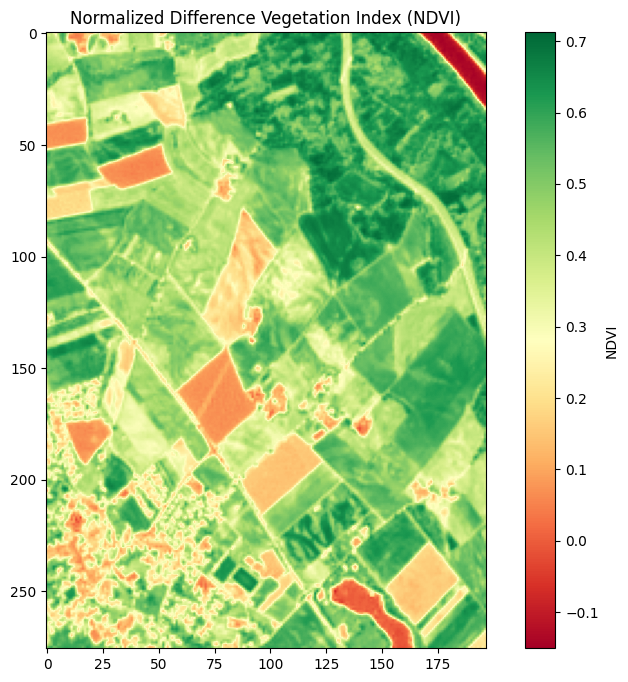

In [58]:
# Open the NIR and Red band raster files
nir_file = rasterio.open(url_nir)
red_file = rasterio.open(url_red)

# Read the data from the raster files
nir_data = nir_file.read(1).astype(float)
red_data = red_file.read(1).astype(float)

# Calculate NDVI
ndvi = (nir_data - red_data) / (nir_data + red_data)

# Display the NDVI image
plt.figure(figsize=(10, 8))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('Normalized Difference Vegetation Index (NDVI)')
plt.show()

2.Calculate zonal stats for the provided field polygon (field_url)

In [71]:
# Read the field polygon shapefile
field_gdf = gpd.read_file(field_url)

# Define the target CRS as EPSG 32632
target_crs = 'EPSG:32632'

# Reproject the field polygon to match the target Nir CRS
project = partial(
    pyproj.transform,
    pyproj.Proj(init=field_gdf.crs),
    pyproj.Proj(init=target_crs)
)
reprojected_field_gdf = field_gdf.copy()
reprojected_field_gdf["geometry"] = reprojected_field_gdf["geometry"].apply(lambda geom: transform(project, geom))

# Specify the affine transformation for the NDVI image
affine_transform = nir_file.transform  # Use the transform from the NIR raster (or red_file.transform if dimensions are the same)

# Calculate zonal statistics
zonal_stats_results = rasterstats.zonal_stats(reprojected_field_gdf, ndvi, affine=affine_transform, stats="mean")

# Add the zonal statistics as a new column in the field GeoDataFrame
reprojected_field_gdf["NDVI_Mean"] = [result["mean"] for result in zonal_stats_results]

# Print the modified GeoDataFrame with zonal statistics
print(reprojected_field_gdf)

                                            geometry  NDVI_Mean
0  POLYGON ((786045.69802 5324334.04997, 786040.8...   0.522626


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior

3.Using the provided land use classification file, what's the "crop" area for the field in field_url.

In [74]:
# Read the field polygon shapefile
field_gdf = gpd.read_file(field_url)

# Read the land use classification file
landuse_gdf = gpd.read_file(landuse_url)

# Spatially join the land use data to the field polygon
joined_gdf = gpd.sjoin(field_gdf, landuse_gdf, how="inner", op="intersects")

# Filter the joined data to "crop" land use class
crop_area = joined_gdf[joined_gdf["land_use"] == "crop"]["geometry"].unary_union.area

print("Crop Area:", crop_area)

Crop Area: 7.132901999998734e-06


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


4.Using the ts_data file, load into a dataframe and find the mean, min and max values for the evi_stdev column

In [75]:
# Load the ts_data into a DataFrame
ts_df = pd.read_csv(ts_data)

# Calculate mean, min, and max values for the evi_stdev column
evi_stdev_mean = ts_df["evi_stdev"].mean()
evi_stdev_min = ts_df["evi_stdev"].min()
evi_stdev_max = ts_df["evi_stdev"].max()

print("EVI Stdev Mean:", evi_stdev_mean)
print("EVI Stdev Min:", evi_stdev_min)
print("EVI Stdev Max:", evi_stdev_max)

EVI Stdev Mean: 308.1499929989086
EVI Stdev Min: 85.53492736816409
EVI Stdev Max: 782.3285522460941


5.What's the CRS zone for the field_url file?

In [76]:
# Read the field polygon shapefile
field_gdf = gpd.read_file(field_url)

# Get the CRS information
crs = field_gdf.crs

print("CRS:", crs)

CRS: EPSG:4326


6.What's the CRS zone for the url_nir file?

In [77]:
# Open the NIR raster file
nir_file = rasterio.open(url_nir)

# Get the CRS information
crs = nir_file.crs

print("CRS:", crs)

CRS: EPSG:32632


Unfortunately, I couldn't execute the assigned tasks in Colab. This happened because my knowledge of this platform is not so extensive. I tried a few things, but they all ended up unsuccessful. I searched for references, but none of them could answer my questions.

As I have always been accustomed to other software and have only recently started exploring online platforms, I tend to believe that I still need a bit more knowledge/training regarding these tools. As mentioned before, my experience has mostly been with conventional methods, so I still need to improve my technical skills with more modern practices.

And I believe that describing step by step how I would do it wouldn't make much sense, as I would need to have a result to know if it worked or not.
